In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

%matplotlib inline

In [110]:
def conv_dates_series(df, col, old_date_format, new_date_format):

    df[col] = pd.to_datetime(df[col], format=old_date_format).dt.strftime(new_date_format)
    
    return df

In [111]:
harvest_data = pd.read_csv("Harvest Yield March-May 2023.csv")

# Remove entries with no date
harvest_data = harvest_data[harvest_data["Date"].notna()]

# convert dates to format used by json files
new_date_format='%Y-%m-%d'
old_date_format='%m/%d/%Y'
harvest_data = conv_dates_series(harvest_data, "Date", old_date_format, new_date_format)

harvest_data

,Date,Row,Batch,Variety,Total kg,Saleable kg,Samples kg,BRIX,TA,BRIX/TA,Total kg (Grade B),Causes (Grade B),Total kg (cull),Causes (cull)
0,2023-03-27,28.0,"8,9",JUK,0.580,0.550,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN
2,2023-03-27,35.0,6,JUK,2.590,2.465,NaN,NaN,NaN,NaN,0.125,NaN,NaN,NaN
3,2023-03-27,34.0,"5,6",JUK,1.290,1.290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2023-03-27,29.0,"7,8",JUK,3.465,3.035,NaN,NaN,NaN,NaN,0.43,NaN,NaN,NaN
7,2023-03-27,33.0,"4,5",JUK,2.280,2.020,NaN,NaN,NaN,NaN,0.26,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,2023-05-22,32.0,4,JUK,1.500,1.060,NaN,NaN,NaN,NaN,0.44,NaN,NaN,NaN
511,2023-05-22,19.0,10,JUK,1.680,1.530,NaN,NaN,NaN,NaN,0.15,NaN,NaN,NaN
512,2023-05-22,31.0,3,JUK,1.055,0.730,NaN,NaN,NaN,NaN,0.325,NaN,NaN,NaN
513,2023-05-22,28.0,NaN,JUK,3.940,3.840,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN


In [112]:
with open('harvestRuleOutput.json') as f:
    rule_data = json.load(f)
rule_data[0]

{'date': '2023-03-26',
 'overall': {'totalFruitCount': 1777,
  'scannedRowCount': 24,
  'scannedUnitCount': 1098},
 'latestHarvestDate': '2023-03-23',
 'regionName': 'All Rows (but differenter)',
 'regionSummary': '\\n         <h1>Region Summary</h1>\\n         Name: All Rows (but differenter) <br/>\\n         # of Full Rows: 72 <br/>\\n         # of Partial Rows: 0 <br/>\\n        ',
 'rows': [{'rowName': 64, 'scannedCount': 45, 'fruitCount': 267},
  {'rowName': 63, 'scannedCount': 46, 'fruitCount': 180},
  {'rowName': 58, 'scannedCount': 46, 'fruitCount': 157},
  {'rowName': 49, 'scannedCount': 46, 'fruitCount': 120},
  {'rowName': 66, 'scannedCount': 45, 'fruitCount': 116},
  {'rowName': 68, 'scannedCount': 45, 'fruitCount': 111},
  {'rowName': 67, 'scannedCount': 45, 'fruitCount': 95},
  {'rowName': 65, 'scannedCount': 45, 'fruitCount': 93},
  {'rowName': 50, 'scannedCount': 46, 'fruitCount': 87},
  {'rowName': 70, 'scannedCount': 46, 'fruitCount': 78},
  {'rowName': 69, 'scannedCo

In [113]:
for date_entry in rule_data:
    print(f"{date_entry['date']}: {len(date_entry['rows'])}")

2023-03-26: 24
2023-03-29: 46
2023-04-02: 0
2023-04-05: 0
2023-04-09: 0
2023-04-10: 0
2023-04-12: 62
2023-04-17: 8
2023-04-19: 65
2023-04-23: 71
2023-04-26: 71
2023-04-30: 71
2023-05-03: 71
2023-05-07: 71
2023-05-10: 71
2023-05-14: 61
2023-05-17: 71


In [114]:
# Parse json data entry into 2d array, combining counts for fruit in the same gutter
def parse_rule_data(data):
    entries = []
    for date_entry in data:
        # add one day to date to match harvest data, since monitoring was done the day before
        date = (pd.to_datetime(date_entry["date"]) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
        counts = {}
        for row in date_entry['rows']:
            rowNum = np.ceil(row['rowName']/2)
            if rowNum in counts:
                counts[rowNum] += row['fruitCount']
            else: 
                counts[rowNum] = row['fruitCount']
        for rowNum in counts:
            entries.append([date, rowNum, counts[rowNum]])
    return pd.DataFrame(entries, columns=["Date", "Row", "Monitoring Count"])

In [115]:
rule_df = parse_rule_data(rule_data)

In [116]:
df = pd.merge(harvest_data, rule_df, on=['Date', 'Row'], how='outer')

In [117]:
# Confirm that no harvesting was ever done on a monitoring row that reported zero fruits
df.loc[(df["Monitoring Count"] == 0) & df["Total kg"].notna()]

,Date,Row,Batch,Variety,Total kg,Saleable kg,Samples kg,BRIX,TA,BRIX/TA,Total kg (Grade B),Causes (Grade B),Total kg (cull),Causes (cull),Monitoring Count


In [145]:
# Filter down to the data where a nonzero monitoring count was reported
monitored_df = df[
    df["Monitoring Count"].notna() &
    df["Total kg"].notna() &
    df["Monitoring Count"] != 0].copy()

In [146]:
# Add a row calculating the ratio of count/kg
values = monitored_df["Monitoring Count"]/monitored_df["Total kg"]
monitored_df["Count/Kg"] = values

In [147]:
monitored_df

,Date,Row,Batch,Variety,Total kg,Saleable kg,Samples kg,BRIX,TA,BRIX/TA,Total kg (Grade B),Causes (Grade B),Total kg (cull),Causes (cull),Monitoring Count,Count/Kg
0,2023-03-27,28.0,"8,9",JUK,0.580,0.550,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,39.0,67.241379
1,2023-03-27,35.0,6,JUK,2.590,2.465,NaN,NaN,NaN,NaN,0.125,NaN,NaN,NaN,152.0,58.687259
2,2023-03-27,34.0,"5,6",JUK,1.290,1.290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,159.689922
3,2023-03-27,29.0,"7,8",JUK,3.465,3.035,NaN,NaN,NaN,NaN,0.43,NaN,NaN,NaN,194.0,55.988456
4,2023-03-27,33.0,"4,5",JUK,2.280,2.020,NaN,NaN,NaN,NaN,0.26,NaN,NaN,NaN,209.0,91.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023-05-18,28.0,NaN,JUK,1.760,1.620,NaN,NaN,NaN,NaN,0.14,NaN,NaN,NaN,188.0,106.818182
464,2023-05-18,29.0,NaN,JUK,1.300,1.000,NaN,NaN,NaN,NaN,0.3,NaN,NaN,NaN,129.0,99.230769
465,2023-05-18,31.0,3,JUK,0.960,0.595,NaN,NaN,NaN,NaN,0.365,NaN,NaN,NaN,103.0,107.291667
466,2023-05-18,33.0,NaN,JUK,1.300,1.130,NaN,NaN,NaN,NaN,0.17,NaN,NaN,NaN,100.0,76.923077


Text(0, 0.5, 'Frequency')

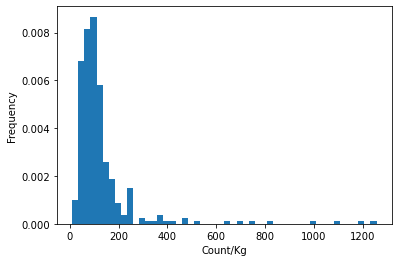

In [172]:
plt.hist(monitored_df["Count/Kg"], bins=50);
plt.xlabel("Count/Kg")
plt.ylabel("Frequency")

In [158]:
truncated_ratios = monitored_df[monitored_df["Count/Kg"] < 400]["Count/Kg"]

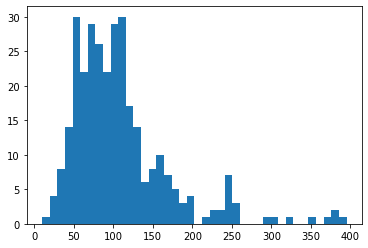

In [159]:
plt.hist(truncated_ratios, bins = 40);
plt.xlabel("Count/Kg")
plt.ylabel("")

In [160]:
np.mean(truncated_ratios)

108.81430398127137

In [161]:
np.std(truncated_ratios)

62.90824748093802

Text(0, 0.5, 'Monitoring Count')

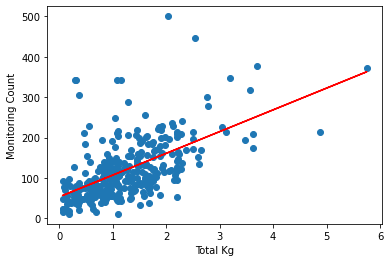

In [170]:
x = monitored_df["Total kg"]
y = monitored_df["Monitoring Count"]
m, b = np.polyfit(x, y, 1)
plt.scatter(x, y)
plt.plot(x, m*x + b, color='red')
plt.xlabel("Total Kg")
plt.ylabel("Monitoring Count")

In [167]:
corr_matrix = np.corrcoef(x, y)
corr = corr_matrix[0,1]
R_sq = corr**2
R_sq

0.325331155394814